## Прогнозирование метрик для оценки эффективности флешмоба

Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-08-13 по 2023-08-19. Ваша задача как аналитика – оценить эффективность этого мероприятия.

1. Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему?
2. Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.
3. Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы.


In [2]:
import pandahouse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from causalimpact import CausalImpact

In [3]:
#подключаемся к схеме данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230820',
    'user':'student',
    'password':'dpo_python_2020'
}

__1. Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему?__

а) Поскольку мероприятие призвано стимулировать пользовательскую активность и увеличивать количество лайков и просмотров на посты, ожидается, что CTR также увеличится. Увеличение CTR будет свидетельствовать о том, что пользователи более активно реагируют на посты во время флэшмоба.

In [4]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    countIf(action = 'like')/countIf(action = 'view') CTR
FROM 
    simulator_20230820.feed_actions 
WHERE hour_time >= toDateTime('2023-07-13 00:00:00')
  AND hour_time <= toDateTime('2023-08-20 00:00:00')
GROUP BY hour_time
ORDER BY 
    hour_time
'''
ctr = pandahouse.read_clickhouse(query, connection=connection)
ctr.tail(3)

,hour_time,CTR
910,2023-08-19 22:00:00,0.205755
911,2023-08-19 23:00:00,0.203413
912,2023-08-20 00:00:00,0.218041


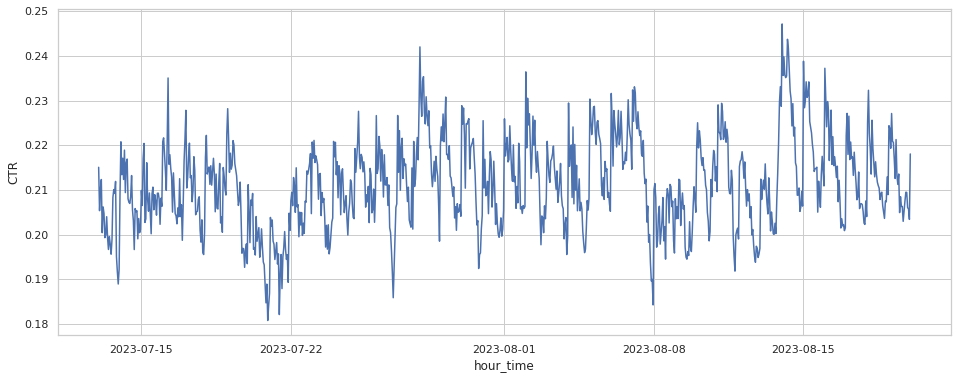

In [6]:
#зададим рисовательный шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

#график изменения CTR
sns.lineplot(x="hour_time", y="CTR", data=ctr );

На графике видно, что 14 августа метрика CTR резко выросла, и потом снова пошла на спад. Во время флешмоба значения метрики CTR выше 0.2 и заметны небольшие изменения, что говорит о хорошей реакции пользователей на контент.

б) Так же ожидается увеличение количества публикаций в ленте новостей в связи с активным участием пользователей в флэшмобе. Это происходит из-за того, что участники должны делать посты, чтобы участвовать в конкурсе.

In [7]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    uniqExact(post_id) num_posts
FROM 
    simulator_20230820.feed_actions
WHERE hour_time >= toDateTime('2023-07-13 00:00:00')
  AND hour_time <= toDateTime('2023-08-20 00:00:00') 
GROUP BY hour_time
ORDER BY 
    hour_time
'''
posts = pandahouse.read_clickhouse(query, connection=connection)
posts.tail(3)

,hour_time,num_posts
910,2023-08-19 22:00:00,257
911,2023-08-19 23:00:00,263
912,2023-08-20 00:00:00,258


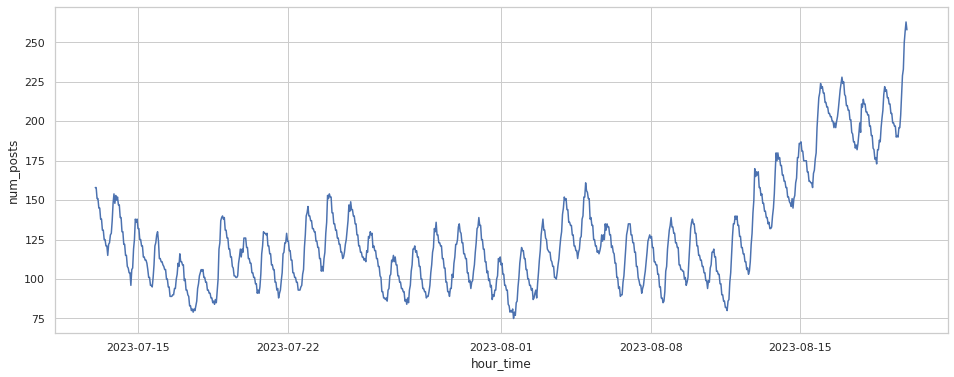

In [8]:
#график изменения количества публикаций
sns.lineplot(x="hour_time", y="num_posts", data=posts);

In [9]:
#посмотрим в какое время было количество постов больше 240
posts[posts.num_posts > 240]

,hour_time,num_posts
909,2023-08-19 21:00:00,250
910,2023-08-19 22:00:00,257
911,2023-08-19 23:00:00,263
912,2023-08-20 00:00:00,258


На графике наблюдается активность по количеству публикаций в ленте новостей во время проведения флешмоба, максимум количества публикаций достигло 19 августа в 23 часа.

в) Поскольку флэшмоб включает в себя конкурс на наибольшее количество лайков, ожидается увеличение числа лайков на публикации участников, а так же увеличение просмотров. Участники будут стараться собрать как можно больше лайков для своих публикаций, чтобы выиграть призы.

In [10]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    sum(action = 'like') as likes,
    sum(action = 'view') as views
FROM 
    simulator_20230820.feed_actions
WHERE hour_time >= toDateTime('2023-07-13 00:00:00')
  AND hour_time <= toDateTime('2023-08-20 00:00:00')
GROUP BY hour_time
ORDER BY 
    hour_time
'''

df = pandahouse.read_clickhouse(query, connection=connection)
df.tail(5)

,hour_time,likes,views
908,2023-08-19 20:00:00,15281,72959
909,2023-08-19 21:00:00,14314,69468
910,2023-08-19 22:00:00,15410,74895
911,2023-08-19 23:00:00,11823,58123
912,2023-08-20 00:00:00,10309,47280


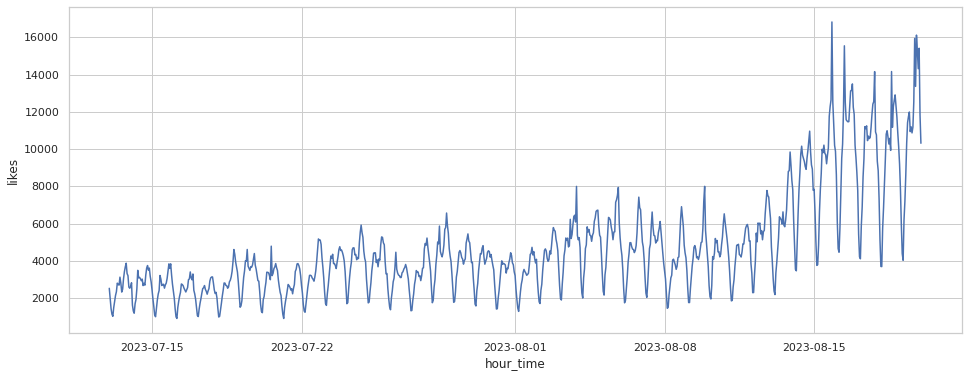

In [11]:
#график изменения количества лайков
sns.lineplot(x="hour_time", y="likes", data=df);

In [12]:
#посмотрим в какое время количество лайков было больше 14000
df[df.likes > 14000] 

,hour_time,likes,views
812,2023-08-15 20:00:00,16821,78828
826,2023-08-16 10:00:00,15541,72139
860,2023-08-17 20:00:00,14155,69873
879,2023-08-18 15:00:00,14159,67673
905,2023-08-19 17:00:00,15936,77595
907,2023-08-19 19:00:00,16115,76926
908,2023-08-19 20:00:00,15281,72959
909,2023-08-19 21:00:00,14314,69468
910,2023-08-19 22:00:00,15410,74895


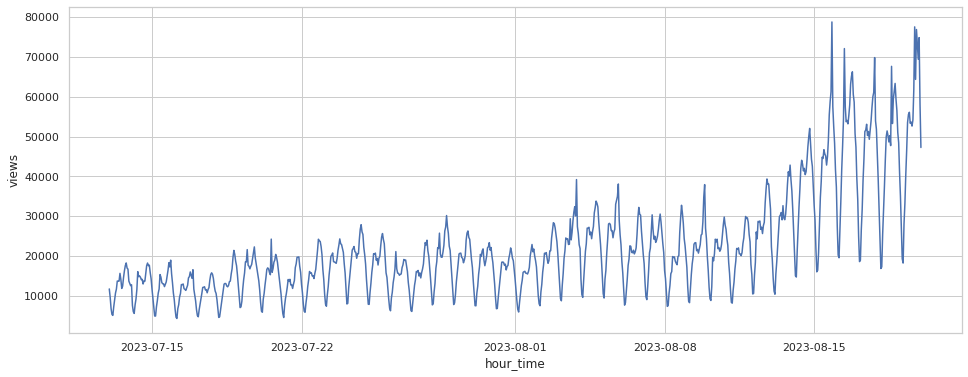

In [13]:
#график изменения количества просмотров
sns.lineplot(x="hour_time", y="views", data=df);

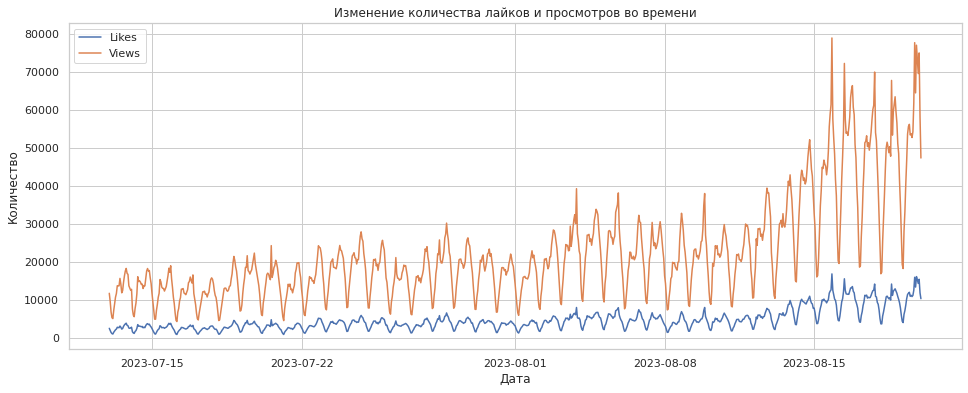

In [14]:
# Подготовка данных 
likes = df[['hour_time', 'likes']]
views = df[['hour_time', 'views']]

plt.figure(figsize=(16, 6))

#Графики количества лайков и просмотров на одной координатной плоскости
sns.lineplot(x="hour_time", y="likes", data=likes, label="Likes")
sns.lineplot(x="hour_time", y="views", data=views, label="Views")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.title('Изменение количества лайков и просмотров во времени')
plt.show()

На графиках заметно увеличение активности во время проведения флешмоба по количеству лайков и просмотров публикаций.

__Вывод__: Увеличение количества публикаций в ленте новостей, лайков и просмотров во время флэшмоба может говорить о том, что данное мероприятие было успешным с точки зрения стимулирования активности пользователей. 

__2. Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.__

a) проверим изменение количества лайков

In [15]:
likes[likes['hour_time'] >= '2023-08-13'].tail(5) 

,hour_time,likes
908,2023-08-19 20:00:00,15281
909,2023-08-19 21:00:00,14314
910,2023-08-19 22:00:00,15410
911,2023-08-19 23:00:00,11823
912,2023-08-20 00:00:00,10309


In [16]:
impact_likes = CausalImpact(data=likes[['likes']],
                            pre_period=[0, 743], 
                            post_period=[744, 911])

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-09-11 19:31:06.327173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-11 19:31:06.327529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-11 19:31:06.348353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-11 19:31:06.348717: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2023-09-11 19:31:08.088305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:31:08.140253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:31:08.212437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2023-09-11 19:33:49.744850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-11 19:33:49.881621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

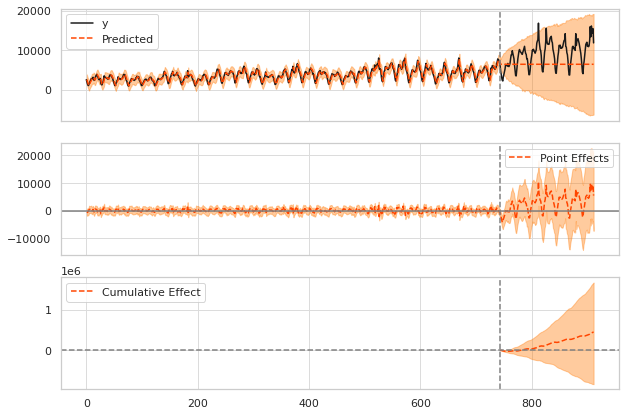

In [17]:
impact_likes.plot()

In [18]:
print(impact_likes.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    9087.09            1526631.0
Prediction (s.d.)         6409.2 (3742.22)   1076746.0 (628693.45)
95% CI                    [-805.23, 13864.02][-135277.91, 2329155.63]

Absolute effect (s.d.)    2677.89 (3742.22)  449885.0 (628693.45)
95% CI                    [-4776.93, 9892.31][-802524.63, 1661908.91]

Relative effect (s.d.)    41.78% (58.39%)    41.78% (58.39%)
95% CI                    [-74.53%, 154.35%] [-74.53%, 154.35%]

Posterior tail-area probability p: 0.24
Posterior prob. of a causal effect: 76.02%

For more details run the command: print(impact.summary('report'))


__В относительном выражении количество лайков показало увеличение на +41.78%.__

б) проверим изменение количества просмотров

In [19]:
impact_views = CausalImpact(data=views[['views']],
                            pre_period=[0, 743], 
                            post_period=[744, 911])

2023-09-11 19:34:34.185129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:34:34.216140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:34:34.990165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:

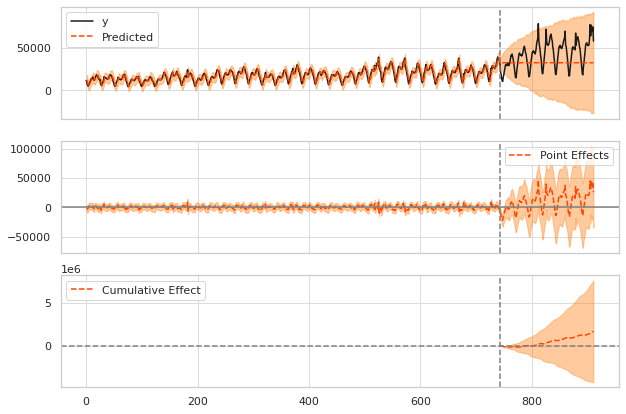

In [20]:
impact_views.plot()

In [21]:
print(impact_views.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    42497.8            7139631.0
Prediction (s.d.)         32566.77 (16905.05)5471218.0 (2840048.79)
95% CI                    [-226.24, 66040.36][-38009.0, 11094780.02]

Absolute effect (s.d.)    9931.03 (16905.05) 1668413.0 (2840048.79)
95% CI                    [-23542.55, 42724.05][-3955149.02, 7177640.0]

Relative effect (s.d.)    30.49% (51.91%)    30.49% (51.91%)
95% CI                    [-72.29%, 131.19%] [-72.29%, 131.19%]

Posterior tail-area probability p: 0.28
Posterior prob. of a causal effect: 72.43%

For more details run the command: print(impact.summary('report'))


__В относительном выражении количество просмотров показало увеличение на +30.49%.__

в) проверим изменение количества публикаций в ленте новостей

In [22]:
impact_posts = CausalImpact(data=posts[['num_posts']],
                            pre_period=[0, 743], 
                            post_period=[744, 911])

2023-09-11 19:42:49.014271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:42:49.050399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:42:49.863532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:

2023-09-11 19:45:33.892716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-11 19:45:34.098226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

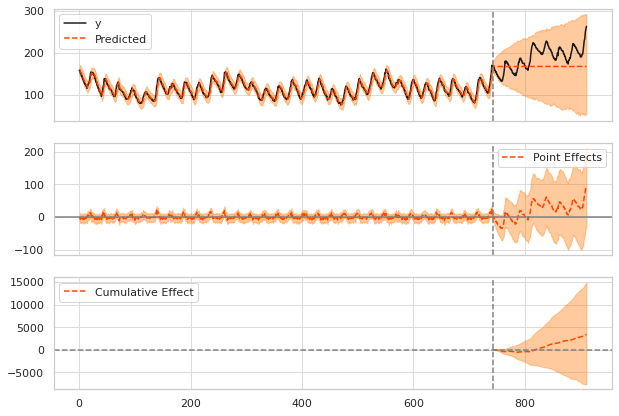

In [23]:
impact_posts.plot()

In [24]:
print(impact_posts.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    187.44             31490.0
Prediction (s.d.)         167.1 (37.07)      28072.06 (6227.58)
95% CI                    [93.74, 239.04]    [15747.58, 40159.27]

Absolute effect (s.d.)    20.34 (37.07)      3417.94 (6227.58)
95% CI                    [-51.6, 93.7]      [-8669.27, 15742.42]

Relative effect (s.d.)    12.18% (22.18%)    12.18% (22.18%)
95% CI                    [-30.88%, 56.08%]  [-30.88%, 56.08%]

Posterior tail-area probability p: 0.3
Posterior prob. of a causal effect: 70.43%

For more details run the command: print(impact.summary('report'))


__В относительном выражении количество публикаций в ленте новостей показало увеличение на +12.18%.__

г) проверим изменение метрики CTR

In [25]:
impact_ctr = CausalImpact(data=ctr[['CTR']],
                            pre_period=[0, 743], 
                            post_period=[744, 911])

2023-09-11 19:46:26.305150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:46:26.347548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:46:27.232029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:

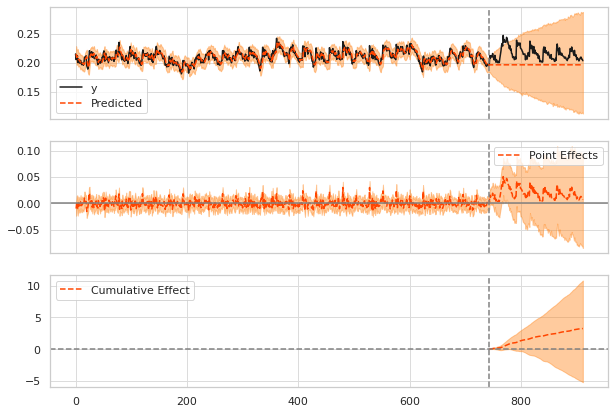

In [26]:
impact_ctr.plot()

In [27]:
print(impact_ctr.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               36.24
Prediction (s.d.)         0.2 (0.03)         32.99 (4.37)
95% CI                    [0.15, 0.25]       [24.62, 41.74]

Absolute effect (s.d.)    0.02 (0.03)        3.25 (4.37)
95% CI                    [-0.03, 0.07]      [-5.5, 11.62]

Relative effect (s.d.)    9.86% (13.24%)     9.86% (13.24%)
95% CI                    [-16.67%, 35.23%]  [-16.67%, 35.23%]

Posterior tail-area probability p: 0.25
Posterior prob. of a causal effect: 75.32%

For more details run the command: print(impact.summary('report'))


__В относительном выражении метрика CTR показала увеличение на +9.86%.__

__3. Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы.__

In [28]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    sum(action = 'like') as likes,
    sum(action = 'view') as views
FROM 
    simulator_20230820.feed_actions
WHERE hour_time >= toDateTime('2023-07-13 00:00:00')
GROUP BY hour_time
ORDER BY 
    hour_time
'''

df_a = pandahouse.read_clickhouse(query, connection=connection)
df_a.head(5)

,hour_time,likes,views
0,2023-07-13 00:00:00,2522,11727
1,2023-07-13 01:00:00,1984,9661
2,2023-07-13 02:00:00,1434,6823
3,2023-07-13 03:00:00,1130,5322
4,2023-07-13 04:00:00,1018,5079


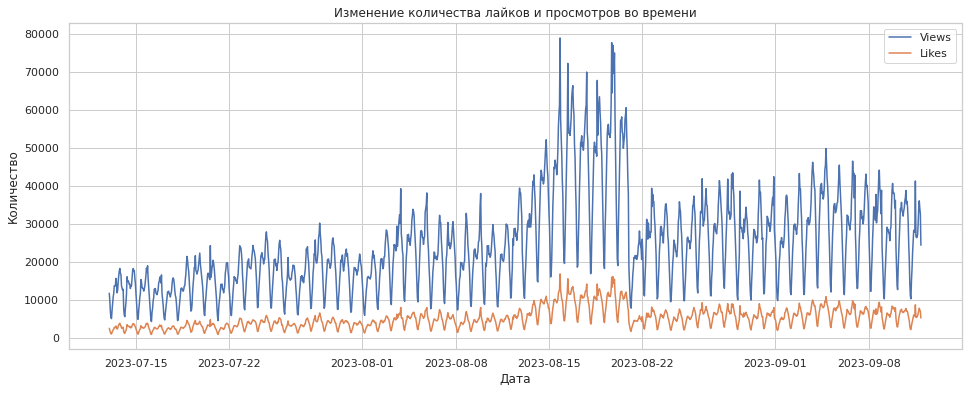

In [29]:
plt.figure(figsize=(16, 6))

#Графики количества лайков и просмотров на одной координатной плоскости
sns.lineplot(x="hour_time", y="views", data=df_a[['hour_time', 'views']], label="Views")
sns.lineplot(x="hour_time", y="likes", data=df_a[['hour_time', 'likes']], label="Likes")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.title('Изменение количества лайков и просмотров во времени')
plt.show()

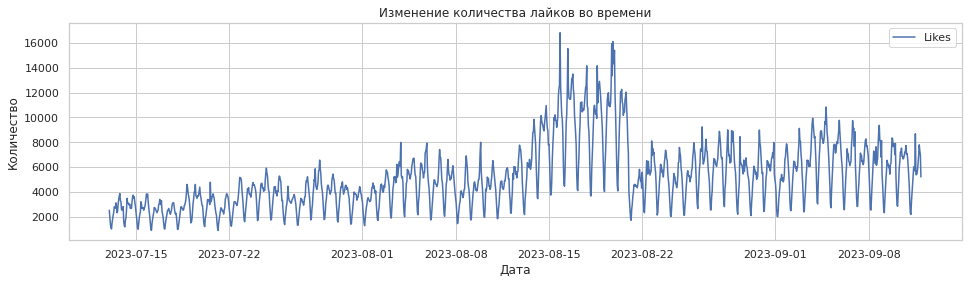

In [30]:
plt.figure(figsize=(16, 4))
sns.lineplot(x="hour_time", y="likes", data=df_a[['hour_time', 'likes']], label="Likes")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.title('Изменение количества лайков во времени')
plt.show()

In [31]:
from pylab import rcParams
import statsmodels.api as sm

In [32]:
df_likes = df_a[['hour_time', 'likes']]
df_likes.loc[:, 'hour_time'] = pd.to_datetime(df_likes['hour_time'])

# Установим индекс DataFrame на столбец с датами
df_likes.set_index('hour_time', inplace=True)
# Сделаем разложение resample по дням
df_lm = df_likes.resample('1D').mean()

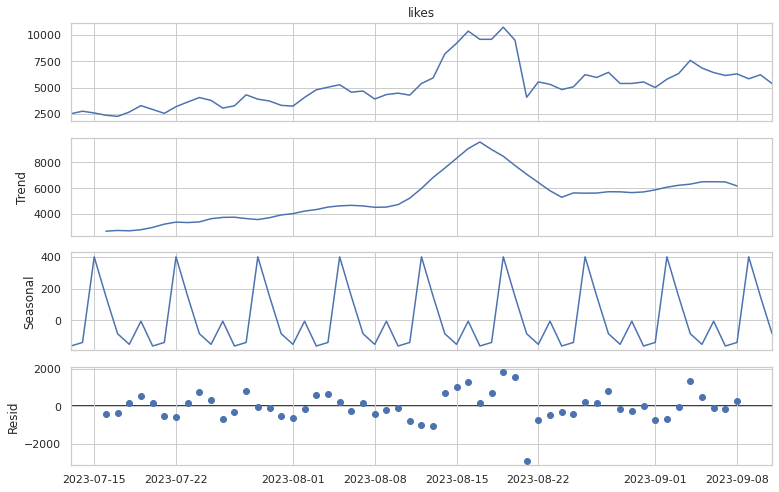

In [33]:
rcParams['figure.figsize'] = 11, 7
decomposition = sm.tsa.seasonal_decompose(df_lm.likes, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

На графиках можно заметить, что до флешмоба наблюдался небольшой тренд, после флешмоба значения вернулись на прежние значения, что особенно хорошо наблюдается на графике trend

Проверим нашу теорию с помощью CausalImpact

In [34]:
df_a.head(3)

,hour_time,likes,views
0,2023-07-13 00:00:00,2522,11727
1,2023-07-13 01:00:00,1984,9661
2,2023-07-13 02:00:00,1434,6823


In [35]:
#сначала проверим на метрике лайков
impact_likes_2 = CausalImpact(data=df_a[['likes']],
                            pre_period=[0, 911], 
                            post_period=[912, 1453])

2023-09-11 19:49:58.821510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:49:58.864712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:49:59.729290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:

2023-09-11 19:53:07.608856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-11 19:53:07.737097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

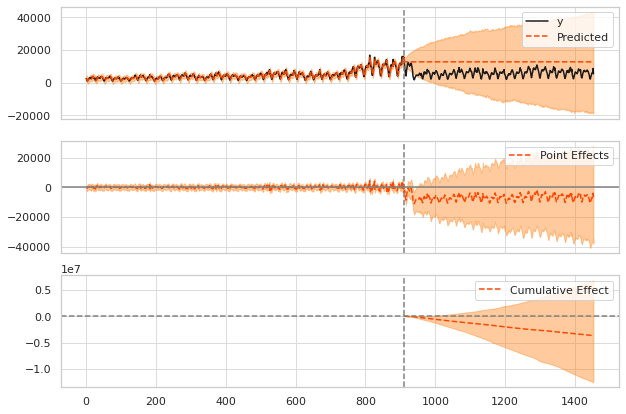

In [36]:
impact_likes_2.plot()

In [37]:
print(impact_likes_2.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5960.15            3230402.0
Prediction (s.d.)         12747.56 (8637.49) 6909180.0 (4681518.74)
95% CI                    [-4123.37, 29734.97][-2234867.11, 16116352.97]

Absolute effect (s.d.)    -6787.41 (8637.49) -3678778.0 (4681518.74)
95% CI                    [-23774.82, 10083.52][-12885950.97, 5465269.11]

Relative effect (s.d.)    -53.24% (67.76%)   -53.24% (67.76%)
95% CI                    [-186.5%, 79.1%]   [-186.5%, 79.1%]

Posterior tail-area probability p: 0.22
Posterior prob. of a causal effect: 78.42%

For more details run the command: print(impact.summary('report'))


In [38]:
print(impact_likes_2.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5960.15. In the absence of an
intervention, we would have expected an average response of 12747.56.
The 95% interval of this counterfactual prediction is [-4123.37, 29734.97].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -6787.41 with a 95% interval of
[-23774.82, 10083.52]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3230402.0.
Had the intervention not taken place, we would have expected
a sum of 6909180.0. The 95% interval of this prediction is [-2234867.11, 16116352.97].


The above results are given in terms of absolute numbers. In relative
terms, the resp

In [39]:
#так же посмотрим значение метрики CTR
q = '''
SELECT 
    toStartOfHour(time) hour_time,
    countIf(action = 'like')/countIf(action = 'view') CTR
FROM 
    simulator_20230820.feed_actions 
WHERE hour_time >= toDateTime('2023-07-13 00:00:00')
GROUP BY hour_time
ORDER BY 
    hour_time
'''
ctr_a = pandahouse.read_clickhouse(q, connection=connection)
ctr_a.tail()

,hour_time,CTR
1458,2023-09-11 18:00:00,0.206685
1459,2023-09-11 19:00:00,0.216372
1460,2023-09-11 20:00:00,0.214680
1461,2023-09-11 21:00:00,0.214220
1462,2023-09-11 22:00:00,0.213770


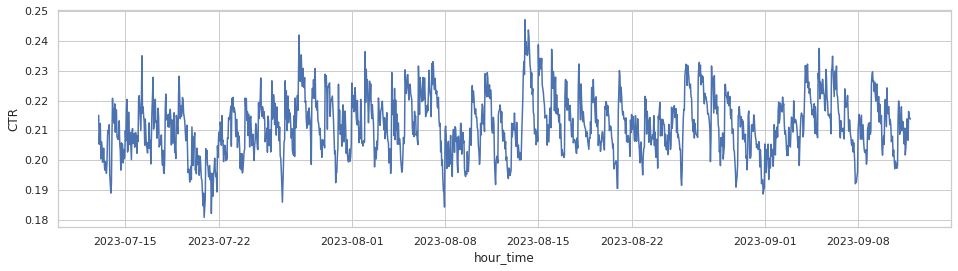

In [40]:
plt.figure(figsize=(16, 4))
sns.lineplot(x="hour_time", y="CTR", data=ctr_a);

In [41]:
impact_ctr_2 = CausalImpact(data=ctr_a[['CTR']],
                            pre_period=[0, 911], 
                            post_period=[912, 1453])

2023-09-11 19:53:27.339924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:53:27.375979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:53:28.174996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-11 19:

2023-09-11 19:56:34.103360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-11 19:56:34.216224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

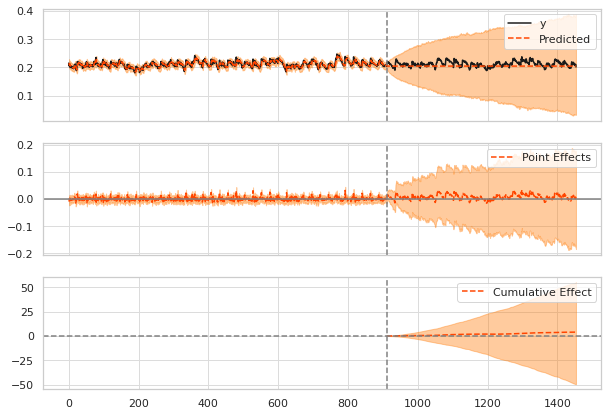

In [42]:
impact_ctr_2.plot()

In [43]:
print(impact_ctr_2.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               114.93
Prediction (s.d.)         0.2 (0.05)         110.91 (26.97)
95% CI                    [0.11, 0.3]        [58.51, 164.25]

Absolute effect (s.d.)    0.01 (0.05)        4.02 (26.97)
95% CI                    [-0.09, 0.1]       [-49.32, 56.42]

Relative effect (s.d.)    3.62% (24.32%)     3.62% (24.32%)
95% CI                    [-44.47%, 50.87%]  [-44.47%, 50.87%]

Posterior tail-area probability p: 0.45
Posterior prob. of a causal effect: 55.34%

For more details run the command: print(impact.summary('report'))


In [44]:
print(impact_ctr_2.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. In the absence of an
intervention, we would have expected an average response of 0.2.
The 95% interval of this counterfactual prediction is [0.11, 0.3].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[-0.09, 0.1]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 114.93.
Had the intervention not taken place, we would have expected
a sum of 110.91. The 95% interval of this prediction is [58.51, 164.25].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +3.62%. The

__Вывод: По полученным данным можно сделать вывод о том, что флешмоб, скорее всего, не оказал существенного долгосрочного воздействия. Это подтверждается к возврату значений на графиках, относительно небольшим абсолютным и относительным эффектом метрики CTR и отрицательным эффектом количества лайков после флешмоба__